In [5]:
import os
import copy
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import time
start = time.time()

from sklearn.model_selection import train_test_split

from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from util import util
from util.VisualizeDataset import VisualizeDataset

In [9]:
DATA_PATH = Path('./data/')
DATASET_FNAME = 'raw_data/processed_data/ch5_own_dataset_updated.csv'
RESULT_FNAME = 'intermediate/chapter7_result_raw.csv'
EXPORT_TREE_PATH = Path('./figures/crowdsignals_ch7_classification/')

In [10]:
N_FORWARD_SELECTION = 50
dataset = pd.read_csv(DATA_PATH / DATASET_FNAME, index_col=0)
dataset.index = pd.to_datetime(dataset.index)

In [11]:
DataViz = VisualizeDataset()
prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(dataset, ['label'], 'like', 0.7, filter=True, temporal=False)

print('Training set length is: ', len(train_X.index))
print('Test set length is: ', len(test_X.index))

Training set length is:  1179
Test set length is:  506


In [14]:
basic_features = ['acc_Acceleration x (m/s^2)', 'acc_Acceleration y (m/s^2)', 'acc_Acceleration z (m/s^2)', 
                  'gyr_Gyroscope x (rad/s)', 'gyr_Gyroscope y (rad/s)', 'gyr_Gyroscope z (rad/s)', 
                  'mag_Magnetic field x', 'mag_Magnetic field y', 'mag_Magnetic field z',
                  'lux_Illuminance (lx)']
pca_features = ['pca_1','pca_2','pca_3','pca_4','pca_5','pca_6','pca_7']
time_features = [name for name in dataset.columns if '_temp_' in name]
freq_features = [name for name in dataset.columns if (('_freq' in name) or ('_pse' in name))]
print('#basic features: ', len(basic_features))
print('#PCA features: ', len(pca_features))
print('#time features: ', len(time_features))
print('#frequency features: ', len(freq_features))
cluster_features = ['cluster']
print('#cluster features: ', len(cluster_features))
features_after_chapter_3 = list(set().union(basic_features, pca_features))
features_after_chapter_4 = list(set().union(basic_features, pca_features, time_features, freq_features))
features_after_chapter_5 = list(set().union(basic_features, pca_features, time_features, freq_features, cluster_features))

#basic features:  10
#PCA features:  7
#time features:  40
#frequency features:  216
#cluster features:  1


In [15]:
fs = FeatureSelectionClassification()
features, ordered_features, ordered_scores = fs.forward_selection(N_FORWARD_SELECTION, 
                                                                  train_X[features_after_chapter_5], 
                                                                  test_X[features_after_chapter_5],
                                                                  train_y,
                                                                  test_y,
                                                                  gridsearch=False)

Added feature0
Added feature1
Added feature2
Added feature3
Added feature4
Added feature5
Added feature6
Added feature7
Added feature8
Added feature9
Added feature10
Added feature11
Added feature12
Added feature13
Added feature14
Added feature15
Added feature16
Added feature17
Added feature18
Added feature19
Added feature20
Added feature21
Added feature22
Added feature23
Added feature24
Added feature25
Added feature26
Added feature27
Added feature28
Added feature29
Added feature30
Added feature31
Added feature32
Added feature33
Added feature34
Added feature35
Added feature36
Added feature37
Added feature38
Added feature39
Added feature40
Added feature41
Added feature42
Added feature43
Added feature44
Added feature45
Added feature46
Added feature47
Added feature48
Added feature49


Figure saved to figures/figure_1.png


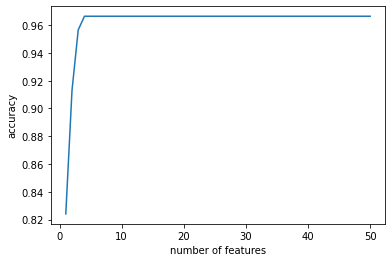

In [16]:
DataViz.plot_xy(x=[range(1, N_FORWARD_SELECTION+1)], y=[ordered_scores],
                xlabel='number of features', ylabel='accuracy')

In [17]:
selected_features = ['acc_Acceleration y (m/s^2)_freq_0.0_Hz_ws_40', 'gyr_Gyroscope x (rad/s)_temp_mean_ws_120',
                     'mag_Magnetic field y_pse', 'mag_Magnetic field x_max_freq', 'gyr_Gyroscope y (rad/s)_freq_weighted', 'gyr_Gyroscope y (rad/s)_freq_1.0_Hz_ws_40',
                     'acc_Acceleration x (m/s^2)_freq_1.9_Hz_ws_40', 'mag_Magnetic field z_freq_0.9_Hz_ws_40', 'acc_Acceleration y (m/s^2)_freq_0.5_Hz_ws_40']


In [18]:
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()
start = time.time()


reg_parameters = [0.0001, 0.001, 0.01, 0.1, 1, 10]
performance_training = []
performance_test = []
## Due to runtime constraints we run the experiment 3 times, yet if you want even more robust data one should increase the repetitions. 
N_REPEATS_NN = 3

In [19]:
for reg_param in reg_parameters:
    performance_tr = 0
    performance_te = 0
    for i in range(0, N_REPEATS_NN):

        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.feedforward_neural_network(
            train_X, train_y,
            test_X, hidden_layer_sizes=(250, ), alpha=reg_param, max_iter=500,
            gridsearch=False
        )

        performance_tr += eval.accuracy(train_y, class_train_y)
        performance_te += eval.accuracy(test_y, class_test_y)
    performance_training.append(performance_tr/N_REPEATS_NN)
    performance_test.append(performance_te/N_REPEATS_NN)

ValueError: x and y must have same first dimension, but have shapes (6,) and (4,)

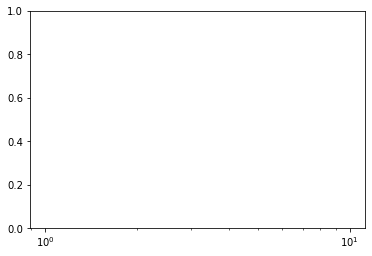

In [29]:
DataViz.plot_xy(x=[reg_parameters, reg_parameters], y=[performance_training, performance_test], method='semilogx',
                xlabel='regularization parameter value', ylabel='accuracy', ylim=[0.95, 1.01],
                names=['training', 'test'], line_styles=['r-', 'b:'])

In [21]:
leaf_settings = [1,2,5,10]
performance_training = []
performance_test = []

In [22]:
for no_points_leaf in leaf_settings:

    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.decision_tree(
        train_X[selected_features], train_y, test_X[selected_features], min_samples_leaf=no_points_leaf,
        gridsearch=False, print_model_details=False)

    performance_training.append(eval.accuracy(train_y, class_train_y))
    performance_test.append(eval.accuracy(test_y, class_test_y))

Figure saved to figures/figure_3.png


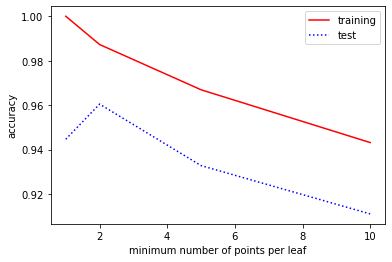

In [23]:
DataViz.plot_xy(x=[leaf_settings, leaf_settings], y=[performance_training, performance_test],
                xlabel='minimum number of points per leaf', ylabel='accuracy',
                names=['training', 'test'], line_styles=['r-', 'b:'])

In [24]:
possible_feature_sets = [basic_features, features_after_chapter_3, features_after_chapter_4, features_after_chapter_5, selected_features]
feature_names = ['initial set', 'Chapter 3', 'Chapter 4', 'Chapter 5', 'Selected features']
N_KCV_REPEATS = 5


print('Preprocessing took', time.time()-start, 'seconds.')

scores_over_all_algs = []

Preprocessing took 75.2640790939331 seconds.


In [25]:
for i in range(0, len(possible_feature_sets)):
    selected_train_X = train_X[possible_feature_sets[i]]
    selected_test_X = test_X[possible_feature_sets[i]]

    # First we run our non deterministic classifiers a number of times to average their score.

    performance_tr_nn = 0
    performance_tr_rf = 0
    performance_tr_svm = 0
    performance_te_nn = 0
    performance_te_rf = 0
    performance_te_svm = 0

    for repeat in range(0, N_KCV_REPEATS):
        print("Training NeuralNetwork run {} / {} ... ".format(repeat, N_KCV_REPEATS, feature_names[i]))
        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.feedforward_neural_network(
            selected_train_X, train_y, selected_test_X, gridsearch=True
        )
        print("Training RandomForest run {} / {} ... ".format(repeat, N_KCV_REPEATS, feature_names[i]))
        performance_tr_nn += eval.accuracy(train_y, class_train_y)
        performance_te_nn += eval.accuracy(test_y, class_test_y)
        
        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.random_forest(
            selected_train_X, train_y, selected_test_X, gridsearch=True
        )
        
        performance_tr_rf += eval.accuracy(train_y, class_train_y)
        performance_te_rf += eval.accuracy(test_y, class_test_y)

        print("Training SVM run {} / {}, featureset: {}... ".format(repeat, N_KCV_REPEATS, feature_names[i]))
      
        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.support_vector_machine_with_kernel(
            selected_train_X, train_y, selected_test_X, gridsearch=True
        )
        performance_tr_svm += eval.accuracy(train_y, class_train_y)
        performance_te_svm += eval.accuracy(test_y, class_test_y)

    
    overall_performance_tr_nn = performance_tr_nn/N_KCV_REPEATS
    overall_performance_te_nn = performance_te_nn/N_KCV_REPEATS
    overall_performance_tr_rf = performance_tr_rf/N_KCV_REPEATS
    overall_performance_te_rf = performance_te_rf/N_KCV_REPEATS
    overall_performance_tr_svm = performance_tr_svm/N_KCV_REPEATS
    overall_performance_te_svm = performance_te_svm/N_KCV_REPEATS

#     #And we run our deterministic classifiers:
    print("Determenistic Classifiers:")

    print("Training Nearest Neighbor run 1 / 1, featureset {}:".format(feature_names[i]))
    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.k_nearest_neighbor(
        selected_train_X, train_y, selected_test_X, gridsearch=True
    )
    performance_tr_knn = eval.accuracy(train_y, class_train_y)
    performance_te_knn = eval.accuracy(test_y, class_test_y)
    print("Training Descision Tree run 1 / 1  featureset {}:".format(feature_names[i]))
    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.decision_tree(
        selected_train_X, train_y, selected_test_X, gridsearch=True
    )
    
    performance_tr_dt = eval.accuracy(train_y, class_train_y)
    performance_te_dt = eval.accuracy(test_y, class_test_y)
    print("Training Naive Bayes run 1/1 featureset {}:".format(feature_names[i]))
    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.naive_bayes(
        selected_train_X, train_y, selected_test_X
    )
   
    performance_tr_nb = eval.accuracy(train_y, class_train_y)
    performance_te_nb = eval.accuracy(test_y, class_test_y)

    scores_with_sd = util.print_table_row_performances(feature_names[i], len(selected_train_X.index), len(selected_test_X.index), [
                                                                                                (overall_performance_tr_nn, overall_performance_te_nn),
                                                                                                (overall_performance_tr_rf, overall_performance_te_rf),
                                                                                                (overall_performance_tr_svm, overall_performance_te_svm),
                                                                                                (performance_tr_knn, performance_te_knn),
                                                                                                (performance_tr_knn, performance_te_knn),
                                                                                                (performance_tr_dt, performance_te_dt),
                                                                                                (performance_tr_nb, performance_te_nb)])
    scores_over_all_algs.append(scores_with_sd)


Training NeuralNetwork run 0 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 0 / 5 ... 
Training SVM run 0 / 5, featureset: initial set... 
Training NeuralNetwork run 1 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 1 / 5 ... 
Training SVM run 1 / 5, featureset: initial set... 
Training NeuralNetwork run 2 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 2 / 5 ... 
Training SVM run 2 / 5, featureset: initial set... 
Training NeuralNetwork run 3 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 3 / 5 ... 
Training SVM run 3 / 5, featureset: initial set... 
Training NeuralNetwork run 4 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 4 / 5 ... 
Training SVM run 4 / 5, featureset: initial set... 
Determenistic Classifiers:
Training Nearest Neighbor run 1 / 1, featureset initial set:
Training Descision Tree run 1 / 1  featureset initial set:
Training Naive Bayes run 1/1 featureset initial set:
initial set & 0.9997\emph{( 0.9986 - 1.0007 )}  & 0.9308\emph{( 0.9083 - 0.9534 )} & 0.9993\emph{( 0.9978 - 1.0008 )}  & 0.9490\emph{( 0.9295 - 0.9686 )} & 0.9822\emph{( 0.9745 - 0.9899 )}  & 0.9328\emph{( 0.9105 - 0.9551 )} & 1.0000\emph{( 1.0000 - 1.0000 )}  & 0.9091\emph{( 0.8835 - 0.9347 )} & 1.0000\emph{( 1.0000 - 1.0000 )}  & 0.9091\emph{( 0.8835 - 0.9347 )} & 0.9881\emph{( 0.9818 - 0.9944 )}  & 0.9229\emph{( 0.8992 - 0.9466 )} & 0.6514\emph{( 0.6236 - 0.6792 )}  & 0.6621\emph{( 0.6200 - 0.7041 )}\\\hline
Training NeuralNetwork run 0 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 0 / 5 ... 
Training SVM run 0 / 5, featureset: Chapter 3... 
Training NeuralNetwork run 1 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 1 / 5 ... 
Training SVM run 1 / 5, featureset: Chapter 3... 
Training NeuralNetwork run 2 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 2 / 5 ... 
Training SVM run 2 / 5, featureset: Chapter 3... 
Training NeuralNetwork run 3 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 3 / 5 ... 
Training SVM run 3 / 5, featureset: Chapter 3... 
Training NeuralNetwork run 4 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Training RandomForest run 4 / 5 ... 
Training SVM run 4 / 5, featureset: Chapter 3... 
Determenistic Classifiers:
Training Nearest Neighbor run 1 / 1, featureset Chapter 3:
Training Descision Tree run 1 / 1  featureset Chapter 3:
Training Naive Bayes run 1/1 featureset Chapter 3:
Chapter 3 & 0.9986\emph{( 0.9965 - 1.0008 )}  & 0.9585\emph{( 0.9408 - 0.9762 )} & 0.9998\emph{( 0.9991 - 1.0006 )}  & 0.9755\emph{( 0.9617 - 0.9892 )} & 0.9830\emph{( 0.9755 - 0.9906 )}  & 0.9387\emph{( 0.9174 - 0.9601 )} & 1.0000\emph{( 1.0000 - 1.0000 )}  & 0.9091\emph{( 0.8835 - 0.9347 )} & 1.0000\emph{( 1.0000 - 1.0000 )}  & 0.9091\emph{( 0.8835 - 0.9347 )} & 0.9881\emph{( 0.9818 - 0.9944 )}  & 0.9229\emph{( 0.8992 - 0.9466 )} & 0.7150\emph{( 0.6887 - 0.7413 )}  & 0.7194\emph{( 0.6794 - 0.7593 )}\\\hline
Training NeuralNetwork run 0 / 5 ... 
Training RandomForest run 0 / 5 ... 
Training SVM run 0 / 5, featureset: Chapter 4... 
Training NeuralNetwork run 1 / 5 ... 
Training RandomForest run 1 / 5 ... 
Trai

/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training RandomForest run 0 / 5 ... 
Training SVM run 0 / 5, featureset: Selected features... 
Training NeuralNetwork run 1 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training RandomForest run 1 / 5 ... 
Training SVM run 1 / 5, featureset: Selected features... 
Training NeuralNetwork run 2 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training RandomForest run 2 / 5 ... 
Training SVM run 2 / 5, featureset: Selected features... 
Training NeuralNetwork run 3 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training RandomForest run 3 / 5 ... 
Training SVM run 3 / 5, featureset: Selected features... 
Training NeuralNetwork run 4 / 5 ... 


/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training RandomForest run 4 / 5 ... 
Training SVM run 4 / 5, featureset: Selected features... 
Determenistic Classifiers:
Training Nearest Neighbor run 1 / 1, featureset Selected features:
Training Descision Tree run 1 / 1  featureset Selected features:
Training Naive Bayes run 1/1 featureset Selected features:
Selected features & 0.9708\emph{( 0.9610 - 0.9806 )}  & 0.8711\emph{( 0.8414 - 0.9009 )} & 0.9985\emph{( 0.9962 - 1.0007 )}  & 0.9672\emph{( 0.9514 - 0.9830 )} & 0.9805\emph{( 0.9724 - 0.9885 )}  & 0.9091\emph{( 0.8835 - 0.9347 )} & 1.0000\emph{( 1.0000 - 1.0000 )}  & 0.9012\emph{( 0.8747 - 0.9277 )} & 1.0000\emph{( 1.0000 - 1.0000 )}  & 0.9012\emph{( 0.8747 - 0.9277 )} & 0.9907\emph{( 0.9851 - 0.9963 )}  & 0.9486\emph{( 0.9290 - 0.9682 )} & 0.9042\emph{( 0.8870 - 0.9213 )}  & 0.8696\emph{( 0.8396 - 0.8995 )}\\\hline


Figure saved to figures/figure_4.png


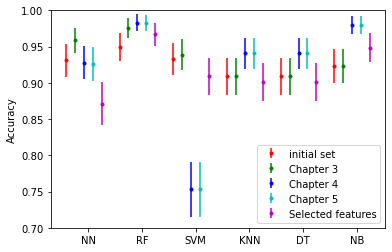

In [26]:
DataViz.plot_performances_classification(['NN', 'RF','SVM', 'KNN', 'DT', 'NB'], feature_names, scores_over_all_algs)

In [27]:
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.decision_tree(train_X[selected_features], train_y, test_X[selected_features],
                                                                                           gridsearch=True,
                                                                                           print_model_details=True, export_tree_path=EXPORT_TREE_PATH)

class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.random_forest(
    train_X[selected_features], train_y, test_X[selected_features],
    gridsearch=True, print_model_details=True)

test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)

{'criterion': 'entropy', 'min_samples_leaf': 2}
Feature importance decision tree:
acc_Acceleration y (m/s^2)_freq_0.0_Hz_ws_40 & 0.4294145373284631
mag_Magnetic field x_max_freq & 0.3643039266131633
gyr_Gyroscope x (rad/s)_temp_mean_ws_120 & 0.11056437738451895
gyr_Gyroscope y (rad/s)_freq_weighted & 0.04447856158167146
mag_Magnetic field z_freq_0.9_Hz_ws_40 & 0.02014068717518917
acc_Acceleration x (m/s^2)_freq_1.9_Hz_ws_40 & 0.013065015043459045
mag_Magnetic field y_pse & 0.008557000779737109
acc_Acceleration y (m/s^2)_freq_0.5_Hz_ws_40 & 0.007499893347192259
gyr_Gyroscope y (rad/s)_freq_1.0_Hz_ws_40 & 0.001976000746605684
{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 100}
Feature importance random forest:
acc_Acceleration y (m/s^2)_freq_0.0_Hz_ws_40 & 0.25024644027025467
mag_Magnetic field x_max_freq & 0.214286994971241
gyr_Gyroscope x (rad/s)_temp_mean_ws_120 & 0.16164563657983164
gyr_Gyroscope y (rad/s)_freq_weighted & 0.15653903120271
acc_Acceleration y (m/s^2)_freq

Figure saved to figures/figure_5.png


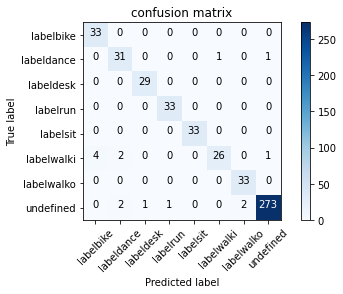

In [28]:
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

### Conclusion
By applying the learning algorithms to our data set, we could predict the activities and see the performance. According to the left figure 4, we notice that the accuracy increases with several features, which is as same as the crowd signal dataset. However, we find that in the right figure, the accuracy of the test set is smaller than 0.95, which means regularization has a great impact on the model's performance, we observe a trend that the performance on the training set goes down. In figure 5, we can see that the accuracy of our test set decreases faster than the crowd signal dataset when the minimum number of points per leaf increases. Moreover, in the right figure, we find that the overall performance of models in our dataset is worsened than crowdsigmal dataset, SVM algorithm performs pretty badly with Chapter 4 and 5 datasets. Finally, in figure 6, we observe a lot of high numbers on the diagonal, indicating high accuracy in both datasets.